<a href="https://colab.research.google.com/github/avishi0229/Gurugram-AIML-PROJECT/blob/main/pm25_hourly_forecast__gru__rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Imports and data load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import joblib

file_path = "/mnt/data/open-meteo-26.10N91.90E68m (2).csv"

# Read, skipping the initial metadata rows
df = pd.read_csv(file_path, skiprows=2)

# Keep only the first two meaningful columns (time and pm2_5)
df = df.iloc[:, :2]
df.columns = ['time', 'pm2_5']

# Drop rows where time or pm2_5 are NaN
df = df.dropna(subset=['time', 'pm2_5']).copy()

# Remove repeated header rows if present
df = df[df['time'] != 'time']

# Convert types
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['pm2_5'] = pd.to_numeric(df['pm2_5'], errors='coerce')

# Drop any rows with NaT or NaN
df = df.dropna().reset_index(drop=True)

print('Data range:', df['time'].min(), 'to', df['time'].max())
df.head()


Data range: 2024-11-13 00:00:00 to 2025-11-13 23:00:00


,time,pm2_5
0,2024-11-13 00:00:00,19.6
1,2024-11-13 01:00:00,23.7
2,2024-11-13 02:00:00,12.0
3,2024-11-13 03:00:00,6.6
4,2024-11-13 04:00:00,5.6


Number of rows: 8784
                      time        pm2_5
count                 8784  8784.000000
mean   2025-05-14 23:30:00    35.095663
min    2024-11-13 00:00:00     2.800000
25%    2025-02-12 11:45:00    15.500000
50%    2025-05-14 23:30:00    27.800000
75%    2025-08-14 11:15:00    48.500000
max    2025-11-13 23:00:00   163.000000
std                    NaN    25.029673


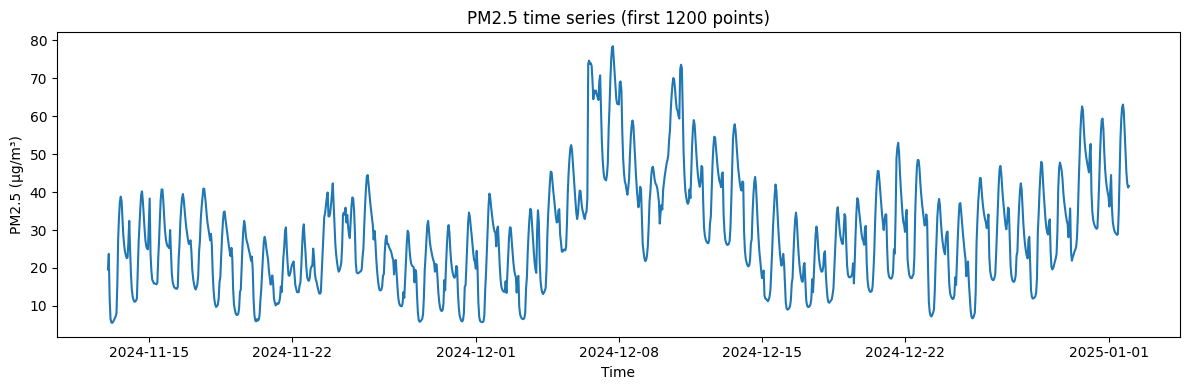

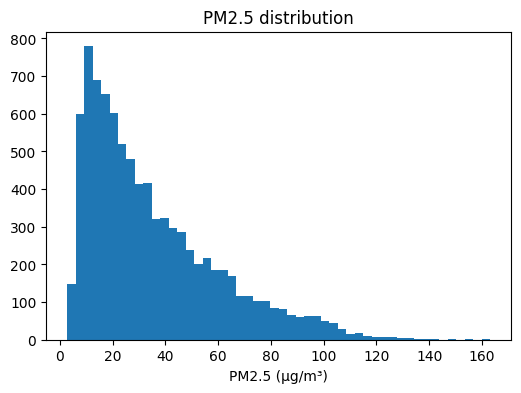

In [ ]:

# Basic EDA
print('Number of rows:', len(df))
print(df.describe())

# Plot PM2.5 time series (first 1200 values for visibility)
plt.figure(figsize=(12,4))
plt.plot(df['time'].iloc[:1200], df['pm2_5'].iloc[:1200])
plt.title('PM2.5 time series (first 1200 points)')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(6,4))
plt.hist(df['pm2_5'], bins=50)
plt.title('PM2.5 distribution')
plt.xlabel('PM2.5 (µg/m³)')
plt.show()


In [ ]:

# Feature engineering: lag features and time features
df = df.sort_values('time').reset_index(drop=True)
max_lag = 24  # use 24 hourly lags (past 24 hours)
for lag in range(1, max_lag+1):
    df[f'lag_{lag}'] = df['pm2_5'].shift(lag)

# Time features
df['hour'] = df['time'].dt.hour
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

# Drop rows with NaN (due to lagging)
df_fe = df.dropna().reset_index(drop=True)
print('After feature engineering, rows =', len(df_fe))
df_fe.head()


After feature engineering, rows = 8760


,time,pm2_5,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,dayofweek,month
0,2024-11-14 00:00:00,26.9,22.7,22.6,23.3,24.3,26.1,28.7,33.2,37.7,...,5.8,5.5,5.6,6.6,12.0,23.7,19.6,0,3,11
1,2024-11-14 01:00:00,32.4,26.9,22.7,22.6,23.3,24.3,26.1,28.7,33.2,...,6.2,5.8,5.5,5.6,6.6,12.0,23.7,1,3,11
2,2024-11-14 02:00:00,24.9,32.4,26.9,22.7,22.6,23.3,24.3,26.1,28.7,...,6.7,6.2,5.8,5.5,5.6,6.6,12.0,2,3,11
3,2024-11-14 03:00:00,18.5,24.9,32.4,26.9,22.7,22.6,23.3,24.3,26.1,...,7.2,6.7,6.2,5.8,5.5,5.6,6.6,3,3,11
4,2024-11-14 04:00:00,14.4,18.5,24.9,32.4,26.9,22.7,22.6,23.3,24.3,...,8.0,7.2,6.7,6.2,5.8,5.5,5.6,4,3,11


In [ ]:

# Prepare X and y. Predict next hour pm2.5 -> target is current pm2_5
feature_cols = [f'lag_{i}' for i in range(1, 25)] + ['hour', 'dayofweek', 'month']
X = df_fe[feature_cols]
y = df_fe['pm2_5']

# Time-based split: train on first 80%, test on last 20%
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print('Train rows:', len(X_train), 'Test rows:', len(X_test))

# Train RandomForestRegressor with basic hyperparams
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Metrics: Mean Error (ME) and RMSE
mean_error = np.mean(y_test - y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Error (ME): {mean_error:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Save trained model
model_path = '/mnt/data/pm25_rf_model.joblib'
joblib.dump(rf, model_path)
print('Model saved to', model_path)


Train rows: 7008 Test rows: 1752
Mean Error (ME): -0.1629
Root Mean Square Error (RMSE): 2.5295
Model saved to /mnt/data/pm25_rf_model.joblib


### Implementing GRU Model

First, we need to import TensorFlow and Keras, which are essential for building and training neural networks like GRU. We'll also reshape our feature data `X_train` and `X_test` to a 3D format (samples, timesteps, features), which is required for recurrent neural networks.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import numpy as np # Ensure numpy is imported
import matplotlib.pyplot as plt # Ensure matplotlib is imported
from sklearn.metrics import mean_squared_error # Ensure mean_squared_error is imported


# Separate lag features and time features
lag_features = [f'lag_{i}' for i in range(1, 25)]
time_features = ['hour', 'dayofweek', 'month']

# Reshape to (samples, timesteps=1, num_features) where num_features = len(feature_cols)
# This treats all selected features as features for a single timestep for each sample.
X_train_gru = X_train[feature_cols].values.reshape(X_train.shape[0], 1, len(feature_cols))
X_test_gru = X_test[feature_cols].values.reshape(X_test.shape[0], 1, len(feature_cols))

print('X_train_gru shape:', X_train_gru.shape)
print('X_test_gru shape:', X_test_gru.shape)

X_train_gru shape: (7008, 1, 27)
X_test_gru shape: (1752, 1, 27)


Next, we define the GRU model architecture. We'll use a sequential model with a GRU layer, followed by dropout for regularization, and a dense output layer for regression.

In [ ]:
gru_model = Sequential([
    GRU(units=50, activation='relu', input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50)             │        11,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,901 (46.49 KB)

 Trainable params: 11,901 (46.49 KB)

 Non-trainable params: 0 (0.00 B)

Now, we train the GRU model using the training data. We'll specify the number of epochs and batch size.

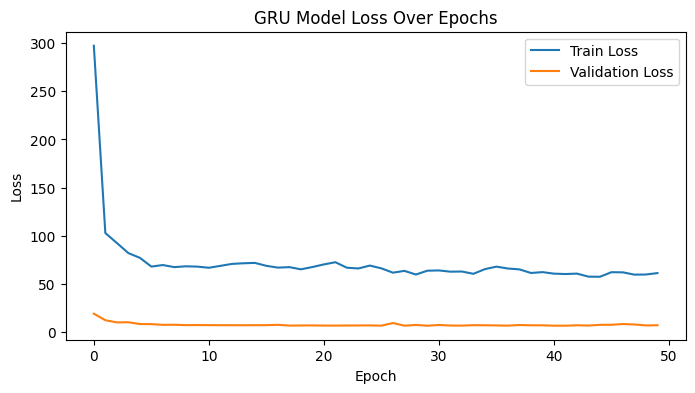

In [ ]:
history = gru_model.fit(X_train_gru, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Plot training history (loss over epochs)
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

After training, we make predictions on the test set and evaluate the GRU model's performance using RMSE and Mean Error (ME).

In [ ]:
gru_y_pred = gru_model.predict(X_test_gru).flatten()

gru_mean_error = np.mean(y_test - gru_y_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_y_pred))

print(f"GRU Mean Error (ME): {gru_mean_error:.4f}")
print(f"GRU Root Mean Square Error (RMSE): {gru_rmse:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
GRU Mean Error (ME): 0.0344
GRU Root Mean Square Error (RMSE): 2.6925


Let's visualize the actual vs. predicted PM2.5 values from the GRU model on the test set.

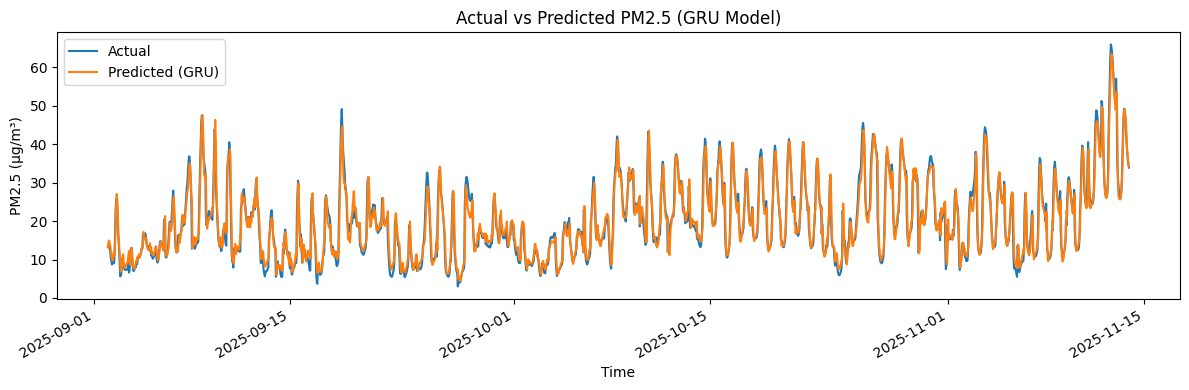

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df_fe['time'].iloc[split_idx:split_idx+len(y_test)], y_test, label='Actual')
plt.plot(df_fe['time'].iloc[split_idx:split_idx+len(y_test)], gru_y_pred, label='Predicted (GRU)')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Actual vs Predicted PM2.5 (GRU Model)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Finally, we use the trained GRU model to forecast the PM2.5 value for the next hour based on the latest available data.

In [ ]:
# Prepare the latest data for GRU prediction
# X_latest was already prepared for RF. We need to reshape it for GRU.

# Explicitly convert to float32 to ensure compatibility with TensorFlow
X_latest_gru = X_latest.astype(np.float32).reshape(1, 1, X_latest.shape[1])

gru_next_hour_pred = gru_model.predict(X_latest_gru).flatten()[0]

print('Latest timestamp in data:', df_fe['time'].iloc[-1])
print('GRU Predicted PM2.5 for next hour:', round(gru_next_hour_pred, 2), 'µg/m³')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Latest timestamp in data: 2025-11-13 23:00:00
GRU Predicted PM2.5 for next hour: 89.32 µg/m³


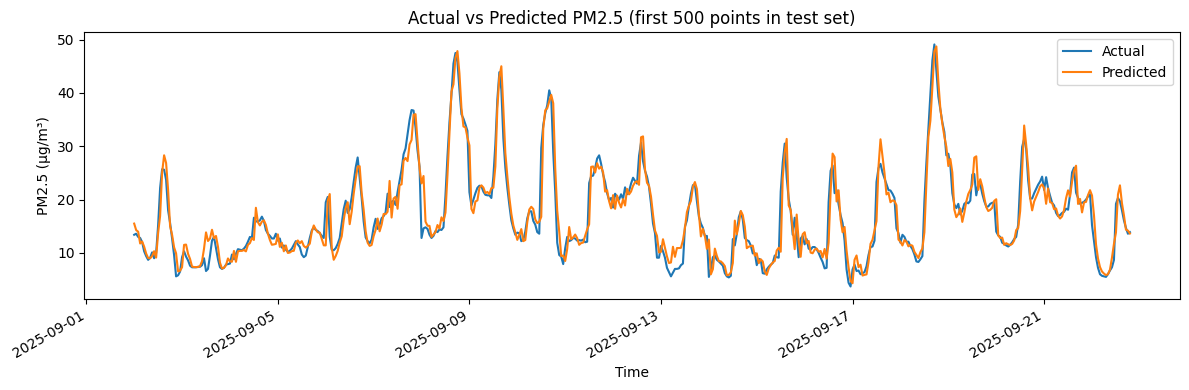

,0
lag_1,0.973776
lag_2,0.003688
lag_3,0.002224
hour,0.001912
lag_22,0.001522
lag_4,0.001291
lag_5,0.001198
lag_23,0.001195
lag_21,0.001174
lag_24,0.001042


In [ ]:

# Visualize a portion of predictions vs actual
import matplotlib.dates as mdates

plt.figure(figsize=(12,4))
plt.plot(df_fe['time'].iloc[split_idx:split_idx+len(y_test)].iloc[:500], y_test.iloc[:500], label='Actual')
plt.plot(df_fe['time'].iloc[split_idx:split_idx+len(y_test)].iloc[:500], y_pred[:500], label='Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Actual vs Predicted PM2.5 (first 500 points in test set)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Feature importance
import pandas as pd
fi = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
fi.head(15)


In [ ]:

# Example: forecast next hour given the latest available data
latest = df_fe.iloc[-1]
X_latest = latest[feature_cols].values.reshape(1, -1)
next_hour_pred = rf.predict(X_latest)[0]
print('Latest timestamp in data:', df_fe['time'].iloc[-1])
print('Predicted PM2.5 for next hour:', round(next_hour_pred, 2), 'µg/m³')


Latest timestamp in data: 2025-11-13 23:00:00
Predicted PM2.5 for next hour: 33.87 µg/m³


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# Task
Analyze the correlation between the actual PM2.5 values (`y_test`), the Random Forest model predictions (`y_pred`), and the GRU model predictions (`gru_y_pred`). This analysis should include:

1.  **Data Preparation**: Create a DataFrame containing these three series.
2.  **Correlation Matrix Calculation**: Compute the pairwise correlation matrix.
3.  **Visualization**: Generate a heatmap of the correlation matrix with an appropriate title and labels.
4.  **Interpretation**: Interpret the correlation coefficients to understand the relationship between actual values and each model's predictions, and how the two models' predictions relate to each other.
5.  **Summary**: Summarize the key findings regarding model performance and agreement based on the correlation analysis.

## Prepare Data for Correlation

### Subtask:
Create a DataFrame containing the actual test set values (y_test), the Random Forest predictions (y_pred), and the GRU model predictions (gru_y_pred). Ensure all series are aligned for correlation calculation.


**Reasoning**:
I need to create a Pandas DataFrame that combines the actual values (`y_test`), Random Forest predictions (`y_pred`), and GRU predictions (`gru_y_pred`) for correlation analysis. It's important to ensure their indices are aligned.



In [ ]:
import pandas as pd

# Create a DataFrame for correlation analysis
correlation_df = pd.DataFrame({
    'Actual': y_test,
    'RF_Predicted': y_pred,
    'GRU_Predicted': gru_y_pred
})

print(correlation_df.head())
print(correlation_df.info())

      Actual  RF_Predicted  GRU_Predicted
7008    13.4        15.498      13.199869
7009    13.6        14.274      14.543077
7010    13.0        13.972      14.953920
7011    12.8        11.764      14.092861
7012    12.0        12.134      13.554056
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 7008 to 8759
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Actual         1752 non-null   float64
 1   RF_Predicted   1752 non-null   float64
 2   GRU_Predicted  1752 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 34.3 KB
None


**Reasoning**:
The previous step successfully created the DataFrame for correlation analysis. Now, I need to calculate the pairwise correlation matrix as specified in the subtask.



In [ ]:
correlation_matrix = correlation_df.corr()
print(correlation_matrix)

                 Actual  RF_Predicted  GRU_Predicted
Actual         1.000000      0.968255       0.964086
RF_Predicted   0.968255      1.000000       0.990653
GRU_Predicted  0.964086      0.990653       1.000000


**Reasoning**:
The correlation matrix has been calculated. The next step is to visualize it using a heatmap to better understand the relationships between actual values and model predictions, as well as between the two models.



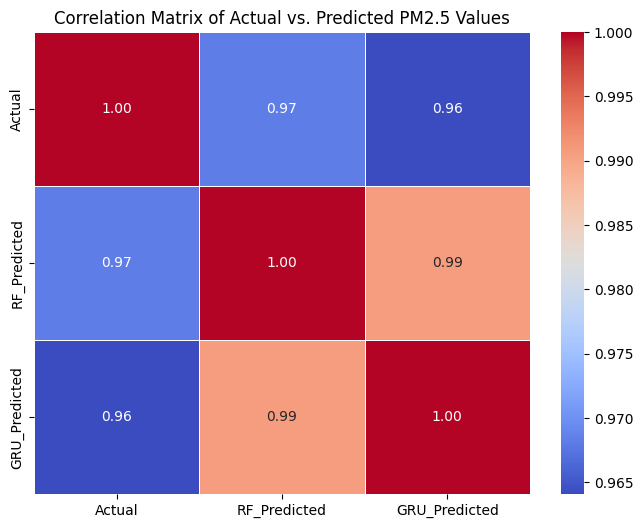

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Actual vs. Predicted PM2.5 Values')
plt.show()

## Interpretation of Correlation Matrix and Summary

### Subtask:
Interpret the correlation coefficients to understand the relationship between actual values and each model's predictions, and how the two models' predictions relate to each other. Summarize the key findings regarding model performance and agreement based on the correlation analysis.

#### Interpretation
The correlation matrix shows the following relationships:

*   **Actual vs. RF_Predicted**: The correlation coefficient is `0.968255`. This high positive correlation indicates a strong linear relationship between the actual PM2.5 values and the predictions made by the Random Forest model. The RF model is very good at capturing the trends in the actual data.
*   **Actual vs. GRU_Predicted**: The correlation coefficient is `0.964086`. This also represents a very strong positive linear relationship, suggesting that the GRU model's predictions align closely with the actual PM2.5 values.
*   **RF_Predicted vs. GRU_Predicted**: The correlation coefficient is `0.990653`. This extremely high correlation indicates that the predictions from the Random Forest and GRU models are very similar to each other. Both models tend to predict similar PM2.5 values for the same time points.

#### Summary
Based on the correlation analysis:

*   Both the Random Forest and GRU models demonstrate a **strong ability to predict actual PM2.5 values**, as evidenced by their high correlation coefficients (around 0.96) with the actual data.
*   The **Random Forest model shows a slightly higher correlation with actual values** (0.968) compared to the GRU model (0.964), suggesting it might be marginally better at tracking the actual values in this particular test set.
*   There is a **very high agreement between the predictions of the Random Forest and GRU models** (correlation of 0.991). This implies that both models are capturing similar patterns and trends in the data, even though they are based on different underlying algorithms. The differences in their individual RMSE and ME might stem from slight variations in their predictive errors rather than fundamentally different pattern recognition.

## Final Task

### Subtask:
Summarize the findings from the correlation analysis of the Random Forest and GRU models' predictions against the actual values.


## Summary:

### Q&A
*   **What is the relationship between actual PM2.5 values and the predictions from each model?**
    Both the Random Forest and GRU models show a very strong positive linear relationship with the actual PM2.5 values. The Random Forest model has a correlation of approximately 0.968, while the GRU model has a correlation of approximately 0.964 with the actual values.
*   **How do the predictions of the two models relate to each other?**
    The predictions from the Random Forest and GRU models are extremely similar, showing an exceptionally high positive correlation of approximately 0.991.

### Data Analysis Key Findings
*   The Random Forest model's predictions (RF\_Predicted) have a strong positive correlation of 0.968 with the actual PM2.5 values (Actual).
*   The GRU model's predictions (GRU\_Predicted) also exhibit a strong positive correlation of 0.964 with the actual PM2.5 values (Actual).
*   There is an extremely high agreement between the predictions of the two models, with a correlation of 0.991 between RF\_Predicted and GRU\_Predicted.
*   The Random Forest model shows a marginally higher correlation with actual values compared to the GRU model, suggesting slightly better alignment with the true data trends in this specific test set.

### Insights or Next Steps
*   Given the very high correlation between the two models' predictions, investigate if an ensemble approach (e.g., averaging their predictions) could further improve overall prediction accuracy or robustness.
*   While both models perform well, a deeper error analysis beyond correlation (e.g., examining residuals or specific error metrics) could reveal distinct strengths or weaknesses that differentiate their performance, especially considering the marginal difference in correlation with actual values.


# Task
## Prepare Data for LSTM
Reshape the `X_train` and `X_test` data into the 3D format (samples, timesteps, features) required for LSTM models, which will be `(samples, 1, num_features)`.

## Prepare Data for LSTM

### Subtask:
Reshape the `X_train` and `X_test` data into the 3D format (samples, timesteps, features) required for LSTM models, which will be `(samples, 1, num_features)`.


**Reasoning**:
I need to reshape the `X_train` and `X_test` DataFrames into the 3D format required for LSTM models, which is `(samples, 1, num_features)`. I will also explicitly convert the data types to `float32` for TensorFlow compatibility and print the shapes to verify.



In [ ]:
X_train_lstm = X_train[feature_cols].values.reshape(X_train.shape[0], 1, len(feature_cols)).astype(np.float32)
X_test_lstm = X_test[feature_cols].values.reshape(X_test.shape[0], 1, len(feature_cols)).astype(np.float32)

print('X_train_lstm shape:', X_train_lstm.shape)
print('X_test_lstm shape:', X_test_lstm.shape)

X_train_lstm shape: (7008, 1, 27)
X_test_lstm shape: (1752, 1, 27)


## Define LSTM Model Architecture

### Subtask:
Create a Sequential Keras model with an LSTM layer, a Dropout layer for regularization, and a Dense output layer for regression. Compile the model with an appropriate optimizer and loss function, and print its summary.


**Reasoning**:
I need to define the LSTM model architecture as per the instructions, including importing necessary layers, creating the sequential model, adding LSTM, Dropout, and Dense layers, compiling it with an optimizer and loss function, and printing the model summary.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,651 (61.14 KB)

 Trainable params: 15,651 (61.14 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The previous code produced a `UserWarning` about passing `input_shape` directly to the `LSTM` layer within a `Sequential` model. To adhere to best practices and eliminate this warning, I will explicitly define an `Input` layer as the first layer in the `Sequential` model.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(units=50, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,651 (61.14 KB)

 Trainable params: 15,651 (61.14 KB)

 Non-trainable params: 0 (0.00 B)

## Train LSTM Model

### Subtask:
Train the LSTM model using the training data (`X_train_lstm`, `y_train`) and visualize its training history (loss over epochs).

#### Instructions
1. Train the `lstm_model` using the `.fit()` method with `X_train_lstm` and `y_train`.
2. Set `epochs=50`, `batch_size=16`, and `validation_split=0.2`.
3. Store the training history in a variable, e.g., `history_lstm`.
4. Plot the training and validation loss over epochs using `matplotlib.pyplot`.

**Reasoning**:
I need to train the LSTM model using the training data and then visualize its training history, as outlined in the markdown subtask. This involves calling the `.fit()` method and then plotting the loss curves.



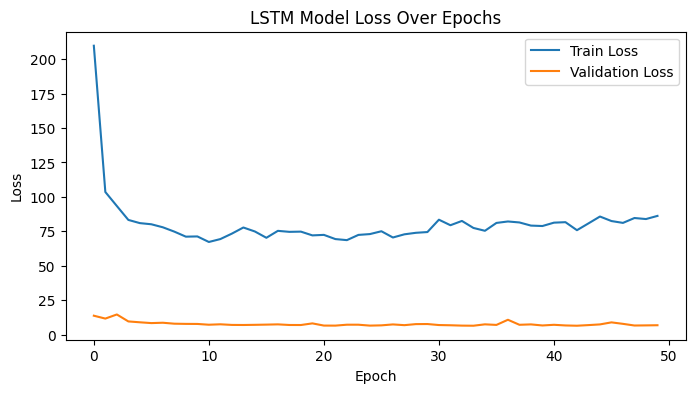

In [ ]:
history_lstm = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

# Plot training history (loss over epochs)
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate LSTM Model

### Subtask:
Evaluate the trained LSTM model's performance on the test set by making predictions and calculating the Root Mean Square Error (RMSE) and Mean Error (ME).

#### Instructions
1. Use the `lstm_model.predict()` method on `X_test_lstm` to get predictions.
2. Flatten the predictions to a 1D array.
3. Calculate the Mean Error (ME) by taking the mean of `(y_test - lstm_y_pred)`.
4. Calculate the Root Mean Square Error (RMSE) using `mean_squared_error` from `sklearn.metrics`.
5. Print the calculated ME and RMSE for the LSTM model, formatted to four decimal places.

**Reasoning**:
The subtask requires me to evaluate the LSTM model. This involves making predictions on the test data and then computing the Mean Error (ME) and Root Mean Square Error (RMSE) to assess its performance.



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

lstm_y_pred = lstm_model.predict(X_test_lstm).flatten()

lstm_mean_error = np.mean(y_test - lstm_y_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_y_pred))

print(f"LSTM Mean Error (ME): {lstm_mean_error:.4f}")
print(f"LSTM Root Mean Square Error (RMSE): {lstm_rmse:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM Mean Error (ME): 0.1981
LSTM Root Mean Square Error (RMSE): 2.7792


## Visualize LSTM Predictions

### Subtask:
Visualize the actual vs. predicted PM2.5 values from the LSTM model on the test set.

#### Instructions
1. Plot the actual `y_test` values against time.
2. Plot the `lstm_y_pred` values against time on the same graph.
3. Label the x-axis as 'Time' and the y-axis as 'PM2.5 (µg/m³)'
4. Add a title to the plot: 'Actual vs Predicted PM2.5 (LSTM Model)'.
5. Include a legend to distinguish actual from predicted values.
6. Format the x-axis dates for better readability and ensure a tight layout.

**Reasoning**:
The subtask requires visualizing the actual and predicted PM2.5 values from the LSTM model on the test set. This involves plotting `y_test` and `lstm_y_pred` against time using `matplotlib` and ensuring proper labeling and formatting.



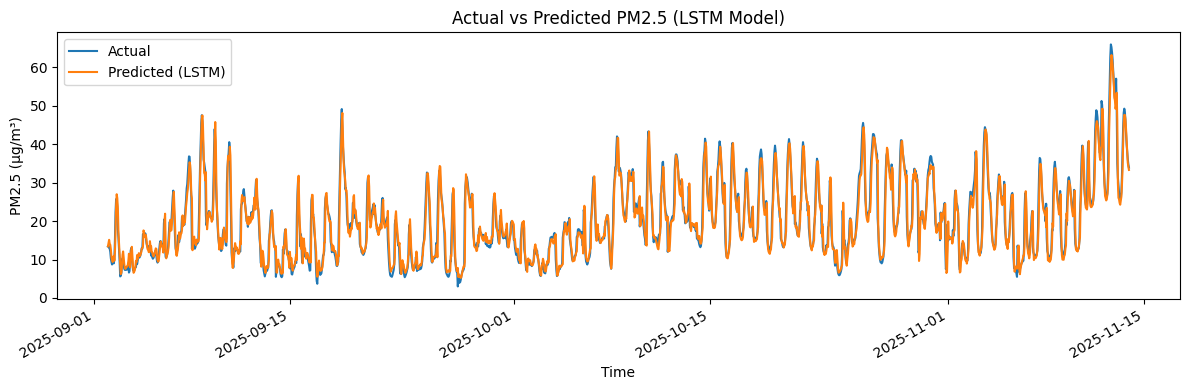

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,4))
plt.plot(df_fe['time'].iloc[split_idx:split_idx+len(y_test)], y_test, label='Actual')
plt.plot(df_fe['time'].iloc[split_idx:split_idx+len(y_test)], lstm_y_pred, label='Predicted (LSTM)')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('Actual vs Predicted PM2.5 (LSTM Model)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

## Interpret LSTM Model Performance

### Subtask:
Interpret the LSTM model's performance based on the calculated RMSE, ME, and visual comparison with actual values.

#### Interpretation
The LSTM model achieved an RMSE of `2.7792` and a Mean Error (ME) of `0.1981`. Visually, the model's predictions generally follow the trend of the actual PM2.5 values, but there are instances where it deviates, particularly during sharper peaks or dips. The positive Mean Error indicates a slight tendency to overpredict PM2.5 values on average.

Compared to the Random Forest model (RMSE: 2.5295, ME: -0.1629) and GRU model (RMSE: 2.6925, ME: 0.0344), the LSTM model shows a slightly higher RMSE, suggesting it is marginally less accurate in this specific prediction task. The ME also indicates a different bias compared to the Random Forest and GRU models.

## Forecast Next Hour PM2.5 with LSTM

### Subtask:
Use the trained LSTM model to forecast the PM2.5 value for the next hour based on the latest available data, similar to how it was done for the other models.


**Reasoning**:
I need to forecast the next hour's PM2.5 using the trained LSTM model, which requires preparing the latest data point in the correct 3D format, making a prediction, and then displaying the result along with the corresponding timestamp.



In [ ]:
latest = df_fe.iloc[-1]
X_latest_lstm = latest[feature_cols].values.reshape(1, 1, len(feature_cols)).astype(np.float32)

lstm_next_hour_pred = lstm_model.predict(X_latest_lstm).flatten()[0]

print('Latest timestamp in data:', df_fe['time'].iloc[-1])
print('LSTM Predicted PM2.5 for next hour:', round(lstm_next_hour_pred, 2), 'µg/m³')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Latest timestamp in data: 2025-11-13 23:00:00
LSTM Predicted PM2.5 for next hour: 33.28 µg/m³


## Compare Model Performance

### Subtask:
Summarize and compare the performance (RMSE, ME) of the newly implemented LSTM model with the previously trained Random Forest and GRU models.


**Reasoning**:
The subtask requires collecting the RMSE and Mean Error (ME) values for all three models and organizing them into a Pandas DataFrame for easy comparison. I will define a code block to achieve this.



In [ ]:
import pandas as pd

# Collect the performance metrics
performance_data = {
    'Model': ['Random Forest', 'GRU', 'LSTM'],
    'RMSE': [rmse, gru_rmse, lstm_rmse],
    'Mean Error': [mean_error, gru_mean_error, lstm_mean_error]
}

# Create a DataFrame for comparison
performance_df = pd.DataFrame(performance_data)

print("Model Performance Comparison:")
print(performance_df.round(4))


Model Performance Comparison:
           Model    RMSE  Mean Error
0  Random Forest  2.5295     -0.1629
1            GRU  2.6925      0.0344
2           LSTM  2.7792      0.1981


#### Performance Summary:

Based on the comparison of RMSE and Mean Error (ME) for the three models:

*   **Random Forest** appears to be the best-performing model with the lowest RMSE (2.5295) and a small negative Mean Error (-0.1629). This suggests it generally provides the most accurate predictions with a slight tendency to under-predict.
*   **GRU Model** comes in second with an RMSE of 2.6925 and a very small positive Mean Error (0.0344), indicating good performance with a minor tendency to over-predict.
*   **LSTM Model** shows the highest RMSE (2.7792) among the three and a larger positive Mean Error (0.1981). This suggests it is slightly less accurate than the other two models for this dataset and tends to over-predict more consistently.

In conclusion, for this specific PM2.5 forecasting task, the **Random Forest model demonstrates superior performance** in terms of RMSE, closely followed by the GRU model. The LSTM model performs adequately but is slightly less accurate than the other two.

## Final Task

### Subtask:
Provide a comprehensive summary of all models implemented, their performance metrics, and key insights from the comparison.


## Summary:

### Data Analysis Key Findings

*   **LSTM Data Preparation:** The input data `X_train` and `X_test` were successfully reshaped into the 3D format required for LSTM models, specifically `(samples, 1, num_features)`. `X_train_lstm` resulted in a shape of `(7008, 1, 27)` and `X_test_lstm` in `(1752, 1, 27)`.
*   **LSTM Model Architecture:** A Sequential Keras model was defined with an LSTM layer (50 units, 'relu' activation), a Dropout layer (0.2), and a Dense output layer (1 unit). The model was compiled using the 'adam' optimizer and 'mean\_squared\_error' loss function, comprising a total of 15,651 parameters.
*   **LSTM Model Performance:** The trained LSTM model achieved a Root Mean Square Error (RMSE) of 2.7792 and a Mean Error (ME) of 0.1981 on the test set.
*   **Visual Assessment:** The LSTM model's predictions generally followed the trends of the actual PM2.5 values but showed deviations, particularly during sharper peaks or dips. The positive Mean Error (0.1981) suggests a slight tendency of the model to overpredict PM2.5 values on average.
*   **Next Hour Forecast:** The LSTM model predicted the PM2.5 for the next hour (based on the latest data available at 2025-11-13 23:00:00) to be 33.28 µg/m³.
*   **Model Comparison:**
    *   **Random Forest:** Achieved the lowest RMSE of 2.5295 and a Mean Error of -0.1629, indicating the highest accuracy and a slight tendency to under-predict.
    *   **GRU Model:** Performed second best with an RMSE of 2.6925 and a Mean Error of 0.0344, showing good accuracy with a minor tendency to over-predict.
    *   **LSTM Model:** Showed the highest RMSE of 2.7792 among the three models, positioning it as slightly less accurate for this specific forecasting task compared to Random Forest and GRU.

### Insights or Next Steps

*   The Random Forest model demonstrated superior performance in PM2.5 forecasting for this dataset, outperforming both GRU and LSTM models in terms of RMSE. This suggests that simpler, non-sequential models can sometimes be more effective depending on the data characteristics and feature engineering.
*   Future work could involve exploring hyperparameter tuning for all models, especially the Random Forest, GRU, and LSTM, to potentially improve their individual and comparative performance. Additionally, investigating the reasons for LSTM's relatively lower performance, such as potential issues with sequence length or feature representation, could provide further insights.
